<a href="https://colab.research.google.com/github/gpfl/telecom-churn/blob/master/telecom_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise Telecom Churn 
*Gustavo Flores*     

Utilizando dados de Churn 
Análise exploratória e previsão de dados de Churn. Para a previsão testei modelos concorrentes:     
* um classificador **RandomForest** (bagging);
* um classificador **catBoost** (boosting);
* um classificador **adaBoost** (boosting);
* um classificador **lightGBM** (boosting). 

### Importando libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, accuracy_score, precision_score, recall_score, auc, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

### Lendo os dados

In [5]:
data = pd.read_csv("churn.csv")
data.rename(index=str, columns={"class": "Churn"}, inplace=True)

type(data), data.shape

(pandas.core.frame.DataFrame, (5000, 21))

## Análise exploratória

Exploração geral dos dados e análise de dispersão das variável.


In [6]:
data.head()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
0,16,128,415,2845,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,2301,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,1616,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,2510,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,155,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [7]:
data.describe()

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,Churn
count,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,25.99840,100.25860,436.911400,2499.500000,0.094600,0.264600,7.755200,180.288900,100.029400,30.649668,200.636560,100.191000,17.054322,200.391620,99.919200,9.017732,10.261780,4.435200,2.771196,1.570400,0.141400
std,14.80348,39.69456,42.209182,1443.520003,0.292691,0.441164,13.546393,53.894699,19.831197,9.162069,50.551309,19.826496,4.296843,50.527789,19.958686,2.273763,2.761396,2.456788,0.745514,1.306363,0.348469
min,0.00000,1.00000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.00000,73.00000,408.000000,1249.750000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.375000,87.000000,14.140000,166.900000,87.000000,7.510000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,26.00000,100.00000,415.000000,2499.500000,0.000000,0.000000,0.000000,180.100000,100.000000,30.620000,201.000000,100.000000,17.090000,200.400000,100.000000,9.020000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,39.00000,127.00000,415.000000,3749.250000,0.000000,1.000000,17.000000,216.200000,113.000000,36.750000,234.100000,114.000000,19.900000,234.700000,113.000000,10.560000,12.000000,6.000000,3.240000,2.000000,0.000000
max,50.00000,243.00000,510.000000,4999.000000,1.000000,1.000000,52.000000,351.500000,165.000000,59.760000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


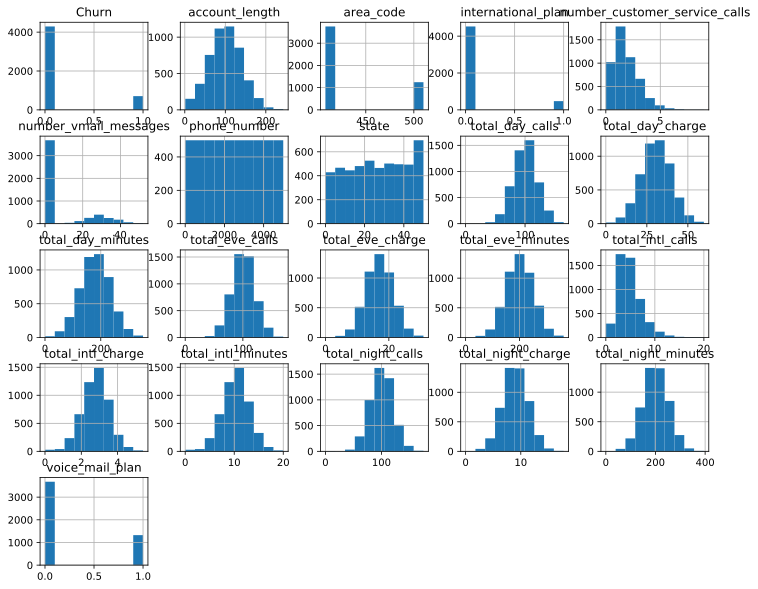

In [8]:
data.hist(figsize=(12,10))
plt.show;

### Analisando dados variável Churn

A variável de interesse `Churn` tem 707 (14,14%) registros de *churned users*, dentre 5000 registros. 

In [9]:
data['Churn'].value_counts()

0    4293
1     707
Name: Churn, dtype: int64

In [10]:
data['Churn'].value_counts(normalize=True)

0    0.8586
1    0.1414
Name: Churn, dtype: float64

Gráfico abaixo mostra que os usuários fieis tendem a fazer menos ligações ao costumer service, enquanto que os usuários *churned* são têm maior peso quando o número de ligações cresce.

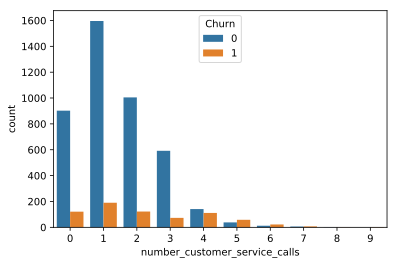

In [11]:
sns.countplot(x='number_customer_service_calls', hue = 'Churn', data = data); 

O Gráfico abaixo demonstra que o grupo de usuários *churned* é mais proporcionalmente mais representativo dentre os usuários que possuem planos internacionais. 

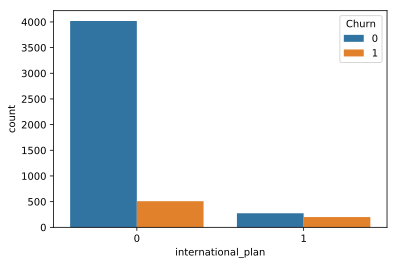

In [12]:
sns.countplot(x='international_plan', hue='Churn', data=data);

## Pré-processamento dos Dados

O dataset será dividido em treino (70%), teste (30%). 

In [13]:
X = data.drop('Churn', axis = 1)
y = data.Churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

{'X_train': X_train.shape, 'X_test': X_test.shape, 'y_train': y_train.shape, 'y_test': y_test.shape}

{'X_test': (1650, 20),
 'X_train': (3350, 20),
 'y_test': (1650,),
 'y_train': (3350,)}

## Treino dos modelos

Os classficadores serão treinados sem calibragem dos hiperparâmetros, apenas como uma análise inicial de qual método seguir.

In [0]:
def roda_modelos(treino_X, treino_y, teste_X, teste_y, classificador):
  
  model_classif = classificador.fit(treino_X, treino_y)
  prediction_prob = model_classif.predict_proba(teste_X)

  fp, tp, t = roc_curve(teste_y, prediction_prob[:, 1])
  y_pred = model_classif.predict(teste_X)
  mean_fp = np.linspace(0, 1, 100)

  metrics = pd.Series(index=['tp','auc','acc','prec','rec','model'], dtype=object)

  metrics['model'] = model_classif
  metrics['acc'] = accuracy_score(teste_y, y_pred)
  metrics['prec'] = precision_score(teste_y, y_pred)
  metrics['rec'] = recall_score(teste_y, y_pred)
  metrics['f1'] = f1_score(teste_y, y_pred)
  metrics['auc'] = auc(fp,tp)
  metrics['tp'] = np.interp(mean_fp, fp, tp)
  metrics['fp'] = mean_fp

  return metrics

O loop abaixo itera a função `roda_modelo` sobre os diferentes classificadores.

In [15]:
modelos = ['RandomForestClassifier', 'AdaBoostClassifier', 'LGBMClassifier', 'CatBoostClassifier']
classificadores = [RandomForestClassifier(), AdaBoostClassifier(), LGBMClassifier(), CatBoostClassifier(silent=True)]

model_metrics = pd.DataFrame(
    index=['fp', 'tp', 'auc', 'acc', 'prec', 'rec', 'f1','model'],
    columns=[modelos])


for modelo, classificador in zip(modelos, classificadores):
  model_metrics[modelo] = roda_modelos(treino_X=X_train, treino_y=y_train, teste_X=X_test, teste_y=y_test, classificador=classificador)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Recall e Precision

Como vimos na análise exploratória acima, os dados de Churn costumam ser desbalanceados, i.e., a proporção de usuários fiéis é muito maior do que a proporção de usuários *churned*. Dessa forma, é muito importante trabalhar com as métricas Recall e Precision. 
* O **Recall**  mede o número de observações corretamente classificadas como positivas (*true positives*) em relação ao total de casos verdadeiramente positivos (*true positives e false negatives*).
* A **Precision**, por sua vez, mede a quantidade de observações corretamente classificadas como positivas (*true positives*) em relação a todas as observações classificadas como positivas (*true positives e false positives*).

Recall é a métrica mais importante no caso do Churn (identificar corretamente os usuários churned), mas não podemos desconsiderar a Precision.

Defini uma função para iterar pelos diferentes classificadores, estimando previsões no **dataset de treino (fora da amostra)** e guardando métricas dos modelos.

In [16]:
for index, classifier in enumerate(modelos):
  print("Model", str(classifier))

  print_out_scores = "Scores \n\
    Accuracy: {} \n\
    Precision: {} \n\
    Recall: {} \n\
    F1 Score: {} \n\
    AUC: {}".format(
    model_metrics.loc['acc',str(classifier)].values,
    model_metrics.loc['prec',str(classifier)].values, 
    model_metrics.loc['rec',str(classifier)].values,
    model_metrics.loc['f1',str(classifier)].values,
    model_metrics.loc['auc',str(classifier)].values)
  
  print(print_out_scores)
  print("\n")

Model RandomForestClassifier
Scores 
    Accuracy: [0.9509090909090909] 
    Precision: [0.9428571428571428] 
    Recall: [0.6991525423728814] 
    F1 Score: [0.8029197080291972] 
    AUC: [0.9151523505861482]


Model AdaBoostClassifier
Scores 
    Accuracy: [0.876969696969697] 
    Precision: [0.6137931034482759] 
    Recall: [0.3771186440677966] 
    F1 Score: [0.4671916010498688] 
    AUC: [0.8593334212355861]


Model LGBMClassifier
Scores 
    Accuracy: [0.9648484848484848] 
    Precision: [0.9494949494949495] 
    Recall: [0.7966101694915254] 
    F1 Score: [0.8663594470046082] 
    AUC: [0.9273787548246349]


Model CatBoostClassifier
Scores 
    Accuracy: [0.9672727272727273] 
    Precision: [0.946078431372549] 
    Recall: [0.8177966101694916] 
    F1 Score: [0.8772727272727273] 
    AUC: [0.9266535612399013]




## Análise dos resultados

### Random Forest
O classificador `RandomForest`, apesar de ter obtido uma boa Accuracy, teve um Recall baixo nos dados de teste. Isso é um indicativo do chamado **lazy prediction**:
  * Como a variável `Churn` é bastante desbalanceada (com 86% das observações sendo `Churn == 0`), o modelo escolhe prever `0` em quase todos os casos, e mesmo assim otimiza sua função de custo (*Information Gain*, no caso dos modelos Random Forest).  

Por causa do desbalanceamento dos dados, devemos olhar mais para as métricas de `Precision`, `Recall` e `F1 Score` (uma ponderação das duas anteriores).

### AdaBoost
O classificador `AdaBoost` teve o pior desempenho em todas as métricas quando submetido aos dados de teste. Esses valores podem indicar um problema de **overfitting**, que, apesar de ser incomum em modelos de *boosting* com *weak lerners*, podem acontecer se o modelo não tem o hiperparâmetro *n_estimators* ajustado. Esse parâmetro limita o número de estimadores utilizados no boosting (ou seja, limita o número de iterações), o que causa um *early stopping* do modelo e evita o overfit.

### LightGBM e CatBoost
Os dois últimos classificadores foram os que melhor performaram na ausência de ajuste fino dos hiperparâmetros. Ambos tiveram os valores mais significativos de `Precision`, `Recall`, `F1 Score` e `AUC`. 


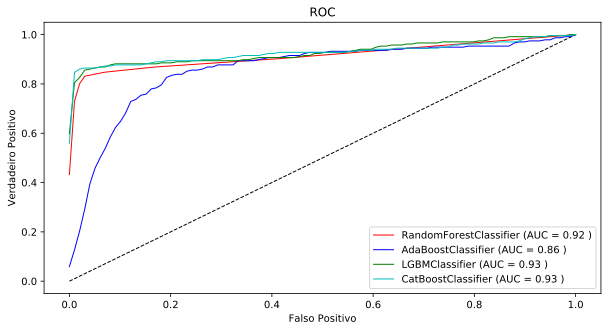

In [17]:
plt.figure(figsize=[10, 5])
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black')
color = ['r', 'b', 'g', 'c']

for index, classifier in enumerate(modelos):
  plt.plot(
      model_metrics.loc['fp'][index],
      model_metrics.loc['tp'][index],
      color=color[index],
      label='%s (AUC = %0.2f )' % (str(
          classifier), model_metrics.loc['auc',str(classifier)]),
          lw=1,
          alpha=1)

plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## Tunning LightGBM

Escolhi ajustar os hiperparâmetros do **LightGBM** para chegar na *melhor previsão possível* para nosso classificador de Churn.     
Os parâmetros trabalhados foram:
* **'max_depth':** controla a 'profundidade' das árvores (número de splits a partir da raiz). 
* **'learning_rate':** 'aprendizado' do classificador, regula a velocidade de convergência do gradiente, i.e., o quanto cada iteração aprende com o erro da anterior.
* **'num_leaves':** número máximo de folhas (nó final da árvore) nos *base learners* (árvores).
* **'border_count':** número máximo de splits que serão utilizados nas variáveis numéricas. Ajuda a mitigar *overfitting*.
* **'boosting_type':** define qual algoritmo de boosting será utilizado pelo classificador.

In [18]:
# LGBMClassifier

lgbm = LGBMClassifier()

param_dist = {"max_depth": np.arange(10, 31, 4),
              "learning_rate" : np.arange(.08, .13, .01),
              "num_leaves": np.arange(21, 42, 5),
              "border_count": [128],
              "boosting_type": ['dart']
             }

lgbm_grid = GridSearchCV(lgbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring=['recall'], refit='recall', verbose=5)
lgbm_model = lgbm_grid.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.9min finished


## Resultado Final

Após um processo de *'grid search'* utilizando um cross valiadation de 3 etapas, e utilizando **recall** como a métrica de interesse, chegamos na especificação abaixo:

In [19]:
lgbm_model.best_estimator_

LGBMClassifier(boosting_type='dart', border_count=128, class_weight=None,
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.09999999999999999, max_depth=22,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=36, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

A métrica de **Recall** apresentou melhora nos dados de treino, assim como o índice **F1 Score**:


In [20]:
lgbm_predict = lgbm_model.predict(X_test)
{'Tunned LGBMClassifier': recall_score(y_test, lgbm_predict),
 'Base LGBMClassifier': model_metrics.loc['rec',str('LGBMClassifier')][0]}

{'Base LGBMClassifier': 0.7966101694915254,
 'Tunned LGBMClassifier': 0.8050847457627118}

Métricas do classificador otimizado:

In [21]:
print_out_scores = "Scores \n\
    Accuracy: {} \n\
    Precision: {} \n\
    Recall: {} \n\
    F1 Score: {} \n\
    AUC: {}".format(
        accuracy_score(y_test, lgbm_predict),
        precision_score(y_test, lgbm_predict),
        recall_score(y_test, lgbm_predict),
        f1_score(y_test, lgbm_predict),
        roc_auc_score(y_test, lgbm_predict))
    
print(print_out_scores)

Scores 
    Accuracy: 0.9654545454545455 
    Precision: 0.945273631840796 
    Recall: 0.8050847457627118 
    F1 Score: 0.8695652173913044 
    AUC: 0.8986526981996021
